In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba,to_rgb

In [2]:
def my_pinv(X,rank):
    U, Σ, Vh = np.linalg.svd(X,full_matrices=False)
    Σ[rank:] = 0.0
    return Vh.T.conj().dot(np.linalg.pinv(np.diag(Σ))).dot(U.T.conj())

def nonzero_filter(eigs):
    return eigs[np.abs(eigs)>1e-12]

In [3]:
# Run all the DMD's
noise_levels = np.logspace(-9,0,20)
normal_reco = []
centered_reco = []

normal_eig_dist = []
centered_eig_dist = []

num_iters = 500

normal_dists = np.zeros((len(noise_levels),num_iters))
centered_dists = np.zeros((len(noise_levels),num_iters))

n_features = 10
T_time_steps = 31
num_eigenvals = 6

def min_dist(computed_eigs,true_eigs):
    return np.sum(np.min(np.abs((computed_eigs[:,np.newaxis] -  true_eigs)),axis=1)**2)

for _i, _σ in enumerate(noise_levels):
    print(_i)
    for p in range(num_iters):
        np.random.seed(p)
        
        # Generate data
        x0 = np.random.randn(n_features)   

        rand_mat = np.random.randn(n_features,n_features) / np.sqrt(n_features) 
        U,Σ,Vh = np.linalg.svd(rand_mat)
        sig = np.zeros((n_features,n_features))
        sig[range(num_eigenvals),range(num_eigenvals)] = Σ[:num_eigenvals]
        A = U @ sig @ Vh
        trunc_eigenvals = np.linalg.eig(A)[0]
        b =  np.random.randn(n_features) * 1.0
        t = np.arange(T_time_steps)
        X = np.zeros((n_features,T_time_steps+1),dtype=complex)
        X[:,0] = x0
        for i in range(1,T_time_steps+1):
            X[:,i] = A @ X[:,i-1] + b
        X = X[:,1:]

        normal_eigs = []
        centered_eigs = []

        eigs = (normal_eigs,centered_eigs)

        X += np.random.randn(*X.shape)*_σ

        # Normal Solution (related to exactDMD)
        normal_alg = {}
        normal_alg['A'] = X[:,1:] @ my_pinv(X[:,:-1],num_eigenvals+1)
        normal_alg['label'] = 'Normal'
        normal_alg['eig'] = np.linalg.eig(normal_alg['A'])[0]

        # Centered solution (related to centering your data)
        centered_alg = {}
        μ1 = X[:,:-1].mean(axis=1)
        μ2 = X[:,1:].mean(axis=1)
        centered_alg['A'] = (X[:,1:] - μ2[:,np.newaxis]) @ my_pinv(X[:,:-1] - μ1[:,np.newaxis],num_eigenvals)
        centered_alg['b'] = μ2 - centered_alg['A'] @ μ1
        centered_alg['label'] = 'Centered'
        centered_alg['eig'] = np.linalg.eig(centered_alg['A'])[0]

        # Make tuple of all algorithms
        algs = (normal_alg,centered_alg)

        # Find the distances between the computed eigenvalues and the true eigenvalues
        min_loc = np.argmin(np.abs(normal_alg['eig'] - 1))
        normal_dists[_i,p] = min_dist(np.concatenate((normal_alg['eig'][:min_loc],normal_alg['eig'][min_loc+1:])),trunc_eigenvals)
        centered_dists[_i,p] = min_dist(centered_alg['eig'],trunc_eigenvals)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


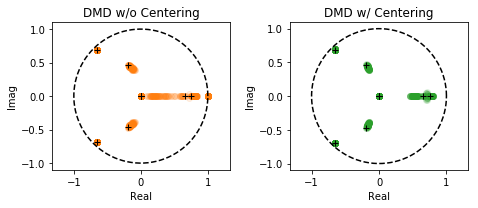

In [4]:
# Run all the DMD's
colors = ['tab:orange', 'tab:green']

n_features = 10
T_time_steps = 30
num_eigenvals = 6

np.random.seed(2)
x0 = np.random.randn(n_features)  

A = np.random.randn(n_features,n_features) / np.sqrt(n_features)

U,Σ,Vh = np.linalg.svd(A)
sig = np.zeros((n_features,n_features))
sig[range(num_eigenvals),range(num_eigenvals)] = Σ[:num_eigenvals]
A_trunc = U.dot(sig).dot(Vh)
trunc_eigenvals = np.linalg.eig(A_trunc)[0]

eigenvals,eigenvects = np.linalg.eig(A_trunc)

b =  np.random.randn(n_features) * 1.0

t = np.arange(T_time_steps)
Y = np.zeros((n_features,T_time_steps+1),dtype=complex)
Y[:,0] = x0
for i in range(1,T_time_steps+1):
    Y[:,i] = A_trunc.dot(Y[:,i-1])+b
Y = Y[:,1:]

normal_eigs = []
centered_eigs = []

eigs = (normal_eigs,centered_eigs)


for _seed in range(100):

    np.random.seed(_seed)
    σ =  0.005
    Y += np.random.randn(*Y.shape)*σ

    # Normal Solution (related to exactDMD)
    normal_alg = {}
    normal_alg['A'] = Y[:,1:].dot(my_pinv(Y[:,:-1],num_eigenvals+1))
    normal_alg['label'] = 'Normal'

    # Centered solution (related to centering your data)
    centered_alg = {}
    μ1 = Y[:,:-1].mean(axis=1)
    μ2 = Y[:,1:].mean(axis=1)
    centered_alg['A'] = (Y[:,1:] - μ2[:,np.newaxis]).dot(my_pinv(Y[:,:-1] - μ1[:,np.newaxis],num_eigenvals))
    centered_alg['b'] = μ2 - centered_alg['A'].dot(μ1)
    centered_alg['label'] = 'Centered'

    # Make tuple of all algorithms
    algs = (normal_alg,centered_alg)

    for _method,_eigs in zip(algs,eigs):
        eigenvals, eigenvects = np.linalg.eig(_method['A'])
        _eigs += list(eigenvals)

plt.figure(figsize=(10,3))
for _k, (_color,_method,_eigs) in enumerate(zip(colors,algs,eigs)):
    plt.subplot(1,3,_k+1)
    plt.scatter(np.real(_eigs),np.imag(_eigs),label=_method['label'],color=_color,alpha=0.1)

    true_eig,_ = np.linalg.eig(A_trunc)
    plt.plot(np.real(true_eig),np.imag(true_eig),'k+')

    temp = np.linspace(0,1,100)
    x = np.cos(2*np.pi*temp)
    y = np.sin(2*np.pi*temp)
    plt.plot(x,y, 'k--')
    plt.axis('equal')

    #plt.title('n=' + str(n_features) + ',' + 'n=' + str(T_time_steps) + ',' + 'r=' + str(num_eigenvals+1))
    plt.title(['DMD w/o Centering','DMD w/ Centering'][_k])
    plt.ylabel('Imag')
    plt.xlabel('Real')
#if k == 2:
#plt.legend()
plt.tight_layout()
plt.show()

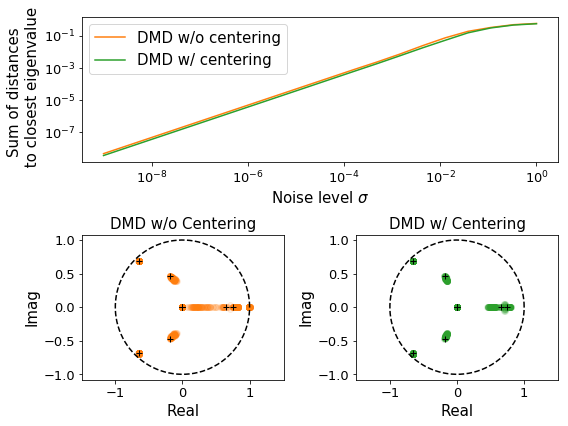

In [5]:
plt.figure(figsize=(8,6))
plt.subplot2grid((2, 2), (0, 0), colspan=2)
plt.plot(noise_levels, np.sqrt(np.median(normal_dists,axis=1)),color=colors[0],label='DMD w/o centering')
plt.plot(noise_levels, np.sqrt(np.median(centered_dists,axis=1)),color=colors[1],label='DMD w/ centering')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Sum of distances \n to closest eigenvalue',fontsize=15)
plt.xlabel(r'Noise level $\sigma$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
for _k, (_color,_method,_eigs) in enumerate(zip(colors,algs,eigs)):
    plt.subplot2grid((2,2),(1,_k),rowspan=1)
    plt.scatter(np.real(_eigs),np.imag(_eigs),label=_method['label'],color=_color,alpha=0.1)

    true_eig,_ = np.linalg.eig(A_trunc)
    plt.plot(np.real(true_eig),np.imag(true_eig),'k+')

    temp = np.linspace(0,1,100)
    x = np.cos(2*np.pi*temp)
    y = np.sin(2*np.pi*temp)
    plt.plot(x,y, 'k--')
    plt.axis('equal')

    #plt.title('n=' + str(m_features) + ',' + 'n=' + str(n_time_steps) + ',' + 'r=' + str(num_eigenvals+1))
    plt.title(['DMD w/o Centering','DMD w/ Centering'][_k],fontsize=15)
    plt.ylabel('Imag',fontsize=15)
    plt.xlabel('Real',fontsize=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
plt.tight_layout()

plt.savefig('../Writeup/Figures/Noise_Analysis.png',dpi=300)